# Import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Flatten, Bidirectional, TimeDistributed, Dropout, BatchNormalization, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import log_loss
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#### google colab 

In [ ]:
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import Dataset

In [2]:
df_merge = pd.read_csv("/home/fshokor/Desktop/Uni/coursprog/RAPMC/datas/all_data_clean.txt",sep="\|\|", engine="python")
df_merge.head()

,ID,Gene,Variation,Class,Text,Score
0,0,FAM58A,truncating mutations,1,"here, we deorphanize cdk10 by identifying cyc...",2
1,1,CBL,w802*,2,the c-cbl loh also positively correlated wit...,1
2,2,CBL,q249e,2,the c-cbl loh also positively correlated wit...,1
3,3,CBL,n454d,3,"most of the changes were novel, although 4 c...",1
4,4,CBL,l399v,4,all mutations from the second group were pre...,1


In [3]:
df_merge.shape

(3316, 6)

In [3]:
# remove stopwords: the,a,an etc.
nltk.download("stopwords")
from nltk.corpus import stopwords
sw = stopwords.words("english")

def pre_processing(data):
  # lowercase text
  data = data.apply(lambda x: " ".join(i.lower() for i in  str(x).split()))
  # remove numeric values
  data = data.str.replace("\d","")
  # remove punctuations
  data = data.str.replace("[^\w\s]","")
  # remove stopwords: the,a,an etc.
  data = data.apply(lambda x: " ".join(i for i in x.split() if i not in sw))
  return data

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fshokor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df_merge['Text']= pre_processing(df_merge['Text'])

/tmp/ipykernel_5194/2263141187.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.str.replace("\d","")
/tmp/ipykernel_5194/2263141187.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.str.replace("[^\w\s]","")


# Text tokenizer

In [5]:
# Use the Keras tokenizer, vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary)
# the maximum number of words to keep, based on word frequency.
num_words = 700 
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_merge['Text'].values) # Updates internal vocabulary based on a list of texts.

In [6]:
# Pad the data 
X = tokenizer.texts_to_sequences(df_merge['Text'].values) # Transforms each text in texts to a sequence of integers, Only top num_words most frequent words will be taken into account.
X = pad_sequences(X, maxlen=700) # transforms a lists of integers into a 2D Numpy array of shape (num_samples, num_timesteps)


# Split the data 

In [7]:
Y_D = pd.get_dummies(df_merge['Class']).values
XD_train, XD_test, YD_train, YD_test = train_test_split(X, Y_D, test_size = 0.2, stratify=Y_D)
# split the train data into train and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(XD_train, YD_train, stratify=YD_train, test_size=0.2)
print(train_df.shape, y_train.shape)
print(cv_df.shape, y_cv.shape)
print(XD_test.shape, YD_test.shape)

(2121, 700) (2121, 9)
(531, 700) (531, 9)
(664, 700) (664, 9)


#### Oversampling 

In [8]:
#!pip install imblearn
import imblearn
from imblearn.over_sampling import RandomOverSampler

In [9]:
oversample = RandomOverSampler(sampling_strategy='minority')

In [12]:
# fit and apply the transform
train_df, y_train = oversample.fit_resample(train_df, y_train)
train_df, y_train = oversample.fit_resample(train_df, y_train)

In [13]:
print(train_df.shape, y_train.shape)

(3303, 700) (3303, 9)


# Model

## Random model

In [14]:
test_data_len =  XD_test.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/rand_probs.sum())[0])

cv_log_loss = round(log_loss(y_cv,cv_predicted_y, eps=1e-15),2)

print("Log loss on Cross Validation Data using Random Model",cv_log_loss)

# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/rand_probs.sum())[0])
test_log_loss = round(log_loss(YD_test,test_predicted_y, eps=1e-15),2)

print("Log loss on Test Data using Random Model",test_log_loss)


Log loss on Cross Validation Data using Random Model 2.55
Log loss on Test Data using Random Model 2.49


## Confusion , Recall, Precision Matrix 

In [14]:

def plot_matrices(model, x_test, y_test): 

  probas = model.predict(x_test)
  pred_indices = np.argmax(probas, axis=1)
  classes = np.array(range(1, 10))
  preds = classes[pred_indices]
  print('Log loss: {}'.format(log_loss(classes[np.argmax(y_test, axis=1)], probas)))
  print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(y_test, axis=1)], preds)))

  confusion  = confusion_matrix(classes[np.argmax(y_test, axis=1)], preds)
  precision =(confusion/confusion.sum(axis=0))
  recall =(((confusion.T)/(confusion.sum(axis=1))).T)
  f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4, gridspec_kw={'width_ratios':[1,1,1,0.08]},figsize=(22,6))
      
  labels = [1,2,3,4,5,6,7,8,9]
  g1 = sns.heatmap(confusion,cbar=False,ax=ax1,annot=True, cmap="Blues", fmt=".3f", xticklabels=labels, yticklabels=labels,)
  g1.set_ylabel('Original Class')
  g1.set_xlabel('Predicted Class')
  g1.set_title('Confusion')
  g2 = sns.heatmap(precision,cmap="Blues",cbar=False,ax=ax2, annot=True,fmt=".3f", xticklabels=labels, yticklabels=labels)
  g2.set_ylabel('Original Class')
  g2.set_xlabel('Predicted Class')
  g2.set_yticks(labels)
  g2.set_title('Precision')
  g3 = sns.heatmap(recall,cmap="Blues",ax=ax3, cbar_ax=axcb, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
  g3.set_ylabel('Original Class')
  g3.set_xlabel('Predicted Class')
  g3.set_title('Recall')
  g3.set_yticks(labels)
      
  for ax in [g1,g2,g3]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=0)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)
      
  plt.show()


## Deep Learning Model

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [16]:
num_words = 700
embed_dim = 128
lstm_out = 64
batch_size = 32

### LSTM

#### Build Model

In [23]:
model = Sequential(
    [
        Embedding(num_words, embed_dim, input_length = X.shape[1]),
        LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2),
        Dense(32, activation = "relu"),
        Dense(9, activation = "relu"),
        Dense(9,activation='softmax')
    ]
)

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

NotImplementedError: Cannot convert a symbolic Tensor (lstm_2/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

#### Plot the model 

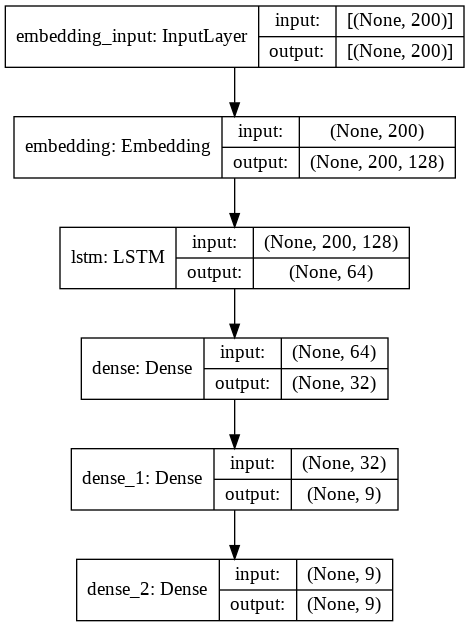

In [ ]:
keras.utils.plot_model(model, "my_first_model_shapes.png", show_shapes= True)

In [ ]:

history = model.fit(train_df, y_train, epochs=100, batch_size=batch_size, validation_data =(cv_df, y_cv) , callbacks=callback)



In [ ]:
loss, accuracy = model.evaluate(train_df, y_train, verbose=False)
print("Training Accuracy: >%.3f"  % (accuracy * 100.0))

#### Testing 

In [ ]:
loss, accuracy = model.evaluate(XD_test, YD_test, verbose=False)
print("Testing Accuracy:  >%.3f"  % (accuracy * 100.0))

#### Plot matrix

Log loss: 3.2831619153268172
Accuracy: 0.4894578313253012


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


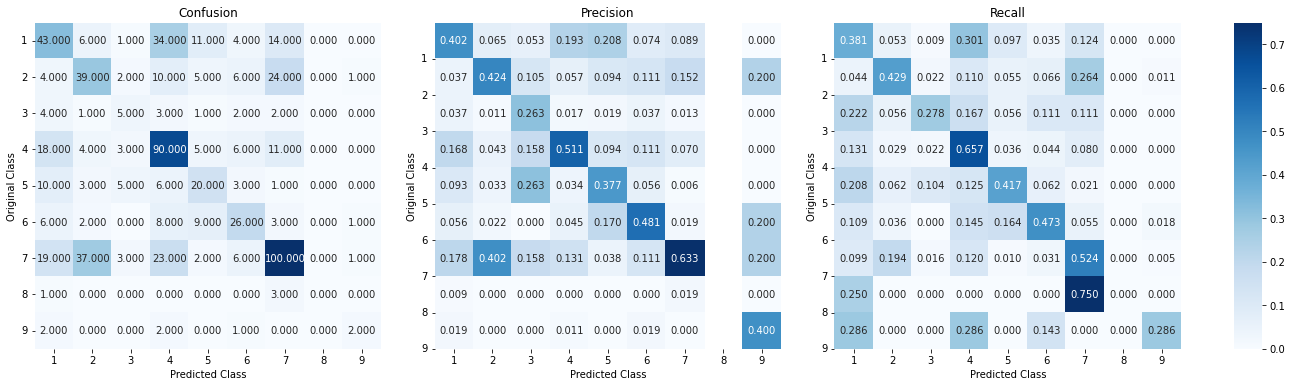

In [ ]:
plot_matrices(model,XD_test, YD_test)

#### Plot Model loss and accuracy

In [ ]:
# list all data history 
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<function matplotlib.pyplot.show>

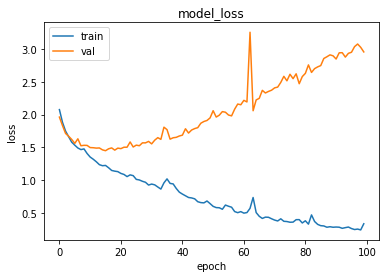

In [ ]:
# visualize training and validation losses  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show 

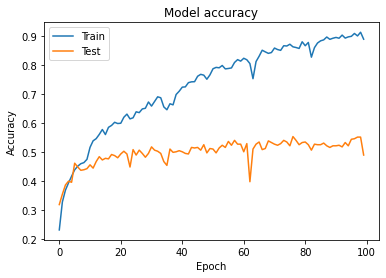

In [ ]:
# visualize training and validation accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### CNN

#### Model building 

In [17]:
cnnmodel = Sequential(
    [
     Embedding(num_words, embed_dim, input_length = X.shape[1]),
     Conv1D(64, 5, activation='relu'),
     GlobalMaxPooling1D(),
     Dropout(0.2),
     Flatten(),
     Dense(16, activation='relu'),
     Dense(9, activation='softmax')
    ]
)
cnnmodel.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
cnnmodel.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 700, 128)          89600     
_________________________________________________________________
conv1d (Conv1D)              (None, 696, 64)           41024     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1

2021-10-19 09:36:39.810327: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-19 09:36:39.810527: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-19 09:36:39.811552: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


#### Plot the model 

In [32]:
!pip install pydot
import pydot

In [55]:
keras.utils.plot_model(cnnmodel, "my_first_model_shapes.png", show_shapes= True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


#### Model Training 

In [18]:
hiscnn = cnnmodel.fit(train_df, y_train,
                     epochs=50,
                     verbose=False,
                     validation_data =(cv_df, y_cv),
                     batch_size= batch_size, callbacks=callback)

2021-10-19 09:36:49.716462: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-19 09:36:49.735991: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1497600000 Hz


In [19]:
loss, accuracy = cnnmodel.evaluate(train_df, y_train, verbose=False)
print("Training Accuracy: >%.3f"  % (accuracy * 100.0))

Training Accuracy: >97.639


#### Model Testing 

In [20]:
loss, accuracy = cnnmodel.evaluate(XD_test, YD_test, verbose=False)
print("Testing Accuracy:  >%.3f"  % (accuracy * 100.0))

Testing Accuracy:  >66.265


#### Plot matrix

Log loss: 1.0923827581185865
Accuracy: 0.6626506024096386


/tmp/ipykernel_5194/2519456330.py:11: RuntimeWarning: invalid value encountered in true_divide
  precision =(confusion/confusion.sum(axis=0))


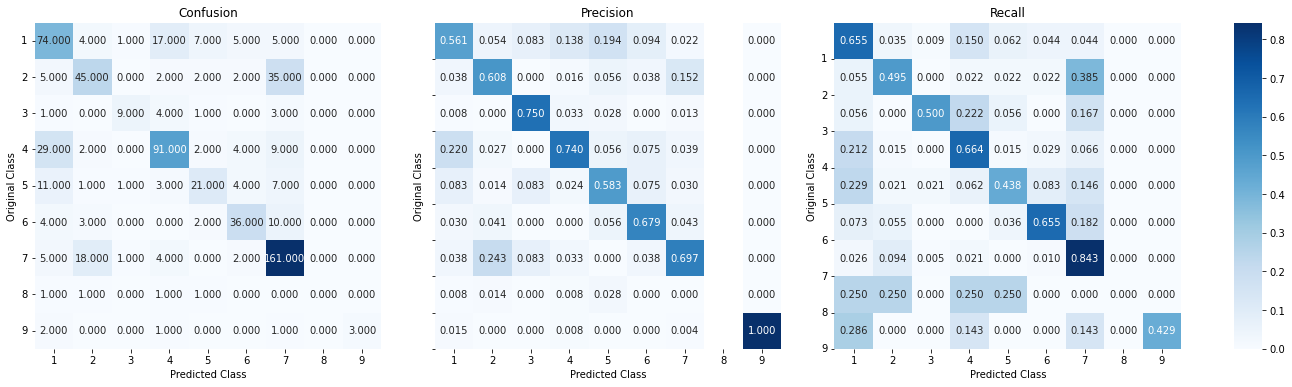

In [21]:
plot_matrices(cnnmodel,XD_test, YD_test )

#### Plot Model loss and accuracy

In [44]:
# list all data history 
print(hiscnn.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<function matplotlib.pyplot.show(close=None, block=None)>

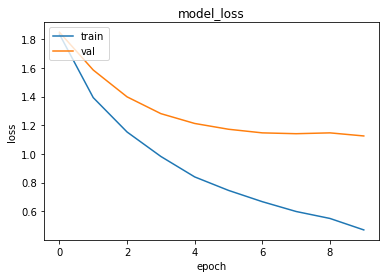

In [45]:
# visualize training and validation losses  
plt.plot(hiscnn.history['loss'])
plt.plot(hiscnn.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show 

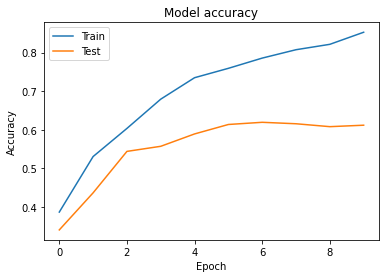

In [46]:
# visualize training and validation accuracies
plt.plot(hiscnn.history['accuracy'])
plt.plot(hiscnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Bidirectional LSTM 

#### Build model

In [47]:
blstmodel = Sequential(
    [
        Embedding(num_words, embed_dim, input_length = X.shape[1]),
        Bidirectional (LSTM (lstm_out,return_sequences=True,dropout=0.50),merge_mode='concat'),
        TimeDistributed(Dense(32,activation='relu')),
        Flatten(),
        Dense(10,activation='relu'),
        Dense(9,activation='softmax')
    ]
)
blstmodel.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
blstmodel.summary()

NotImplementedError: Cannot convert a symbolic Tensor (bidirectional/forward_lstm_3/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

#### Plot the model 

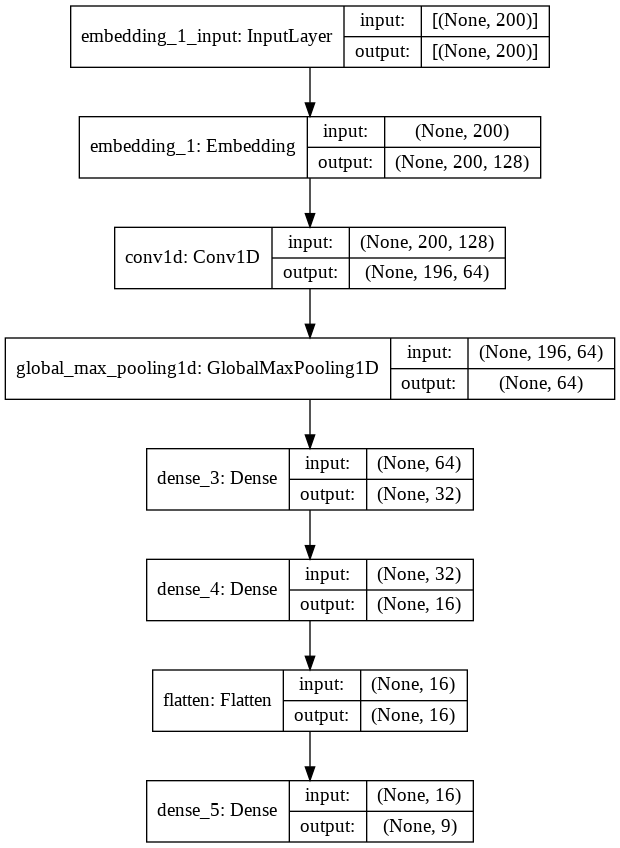

In [ ]:
keras.utils.plot_model(cnnmodel, "my_first_model_shapes.png", show_shapes= True)

#### Model Training 

In [ ]:
his_blstm = blstmodel.fit(train_df, y_train,
                     epochs=50,
                     verbose=False,
                     validation_data =(cv_df, y_cv),
                     batch_size=batch_size,
                     callbacks=callback)

In [ ]:
loss, accuracy = blstmodel.evaluate(train_df, y_train, verbose=False)
print("Training Accuracy: >%.3f"  % (accuracy * 100.0))

Training Accuracy: >94.719


#### Model Testing 

In [ ]:
loss, accuracy = blstmodel.evaluate(XD_test, YD_test, verbose=False)
print("Testing Accuracy:  >%.3f"  % (accuracy * 100.0))

Testing Accuracy:  >48.795


#### Plot matrix

Log loss: 4.616071778650039
Accuracy: 0.4879518072289157


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


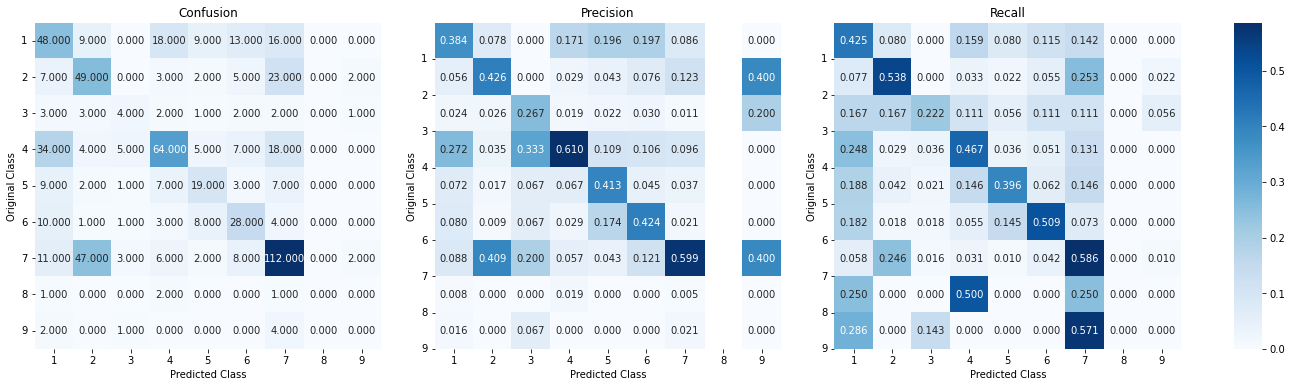

In [ ]:
plot_matrices(blstmodel,XD_test, YD_test)

#### Plot Model loss and accuracy

In [ ]:
# list all data history 
print(his_blstm.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<function matplotlib.pyplot.show>

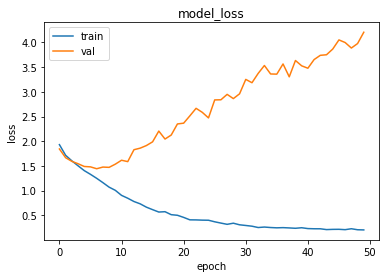

In [ ]:
# visualize training and validation losses  
plt.plot(his_blstm.history['loss'])
plt.plot(his_blstm.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show 

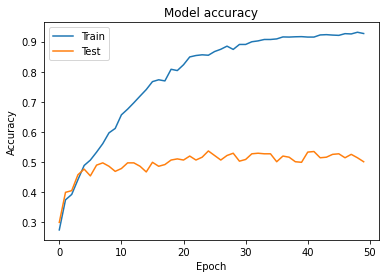

In [ ]:
# visualize training and validation accuracies
plt.plot(his_blstm.history['accuracy'])
plt.plot(his_blstm.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()